In [27]:
import numpy as np
import pandas as pd
import torch

In [67]:
dtype = {
    'datetime': 'string',
    'T': 'float32',
    'RRR': 'float32',
}
data = pd.read_csv('data/weather.csv', sep=';', usecols=[1, 23])
data['date_time'] = data.index
data.reset_index(drop=True, inplace=True)

T - температура

RRR - кол-во осадков

In [111]:
data['RRR'] = data['RRR'].fillna(0.0)
data

,T,RRR,date_time
0,-1.3,3.0,16.12.2024 21:00
1,-2.0,2.0,16.12.2024 18:00
2,-1.3,0,16.12.2024 15:00
3,-1.0,0,16.12.2024 12:00
4,-0.9,0.4,16.12.2024 09:00
...,...,...,...
67385,-6.6,0,01.02.2005 15:00
67386,-7.1,0,01.02.2005 12:00
67387,-8.6,3.0,01.02.2005 09:00
67388,-8.2,2.0,01.02.2005 06:00


In [142]:
df = data.copy()

In [143]:
df['date'] = df['date_time'].apply(lambda x: x.split()[0].strip())
del df['date_time']

In [144]:
df = df[df['T'].notna()]

In [145]:
def replace_str_with_zero(value):
    try:
        np.float64(value)
        return value
    except ValueError:
        return np.float64(0)

# Применяем функцию ко всем значениям в столбце RRR
df['RRR'] = df['RRR'].apply(replace_str_with_zero)

In [146]:
df['temperature'] = df['T'].astype(np.float64)
df['precipitation'] = df['RRR'].astype(np.float64)

del df['T']
del df['RRR']

In [147]:
df = df.groupby('date').agg({'temperature': 'mean', 'precipitation': 'sum'})
df['date'] = df.index
df.reset_index(inplace=True, drop=True)

In [148]:
split_dates = df['date'].str.split('.', expand=True)
split_dates.columns = ['day', 'month', 'year']
split_dates

,day,month,year
0,01,01,2006
1,01,01,2007
2,01,01,2008
3,01,01,2009
4,01,01,2010
...,...,...,...
7252,31,12,2019
7253,31,12,2020
7254,31,12,2021
7255,31,12,2022


In [150]:
df[['day', 'month', 'year']] = split_dates
del df['date']

In [238]:
df['day'] = df['day'].astype(np.int64)
df['month'] = df['month'].astype(np.int64)
df['year'] = df['year'].astype(np.int64)

In [162]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [239]:
# Предположим, что датафрейм называется df
# Целевая переменная
y = df['temperature']

# Признаки
X = df[['day', 'month', 'year']]

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [241]:
from sklearn.model_selection import GridSearchCV

# Задаем параметры для перебора
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10]
}

# GridSearch
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_model = grid_search.best_estimator_
print(grid_search.best_params_)

# Оценка лучшей модели
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Best RMSE: {rmse_best}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 2.5541286803366168


In [242]:
# Создаем модель случайного леса
model = RandomForestRegressor(n_estimators=200, min_samples_split=2, max_depth=20, random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Оценка качества модели (например, RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 2.5541286803366168


In [279]:
pred_d = pd.DataFrame(
    {
        'day': [13],
        'month': [2],
        'year': [2025],
    }
)
model.predict(pred_d)

array([-5.698125])

```

# Сохраняем модель в файл
joblib.dump(model, 'random_forest_model.joblib')

# Загружаем сохранённую модель
loaded_model = joblib.load('random_forest_model.joblib')

# Делаем предсказание на тестовом наборе
predictions = loaded_model.predict(X_test)

```

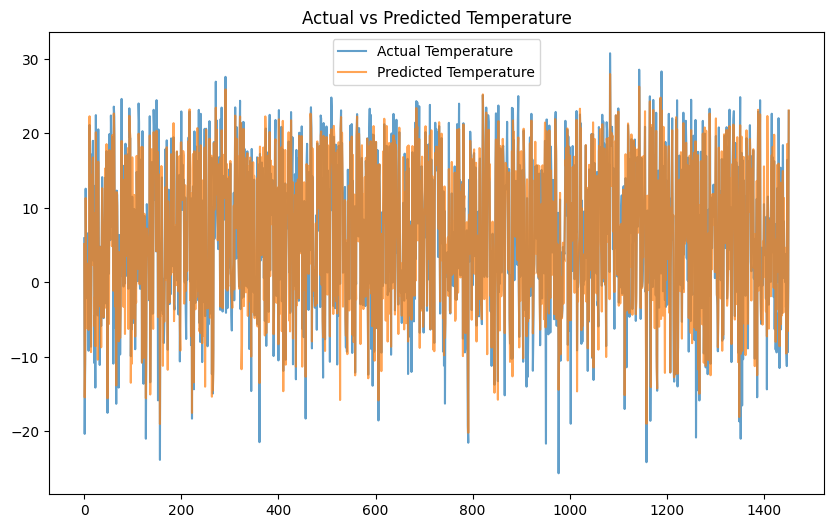

In [166]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Temperature', alpha=0.7)
plt.plot(y_pred, label='Predicted Temperature', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Temperature')
plt.show()

In [167]:
from xgboost import XGBRegressor

In [255]:
df_xgb = df.copy()

In [256]:
# Разделяем данные на признаки и целевую переменную
X = df_xgb[['day', 'month', 'year']]
y = df_xgb['temperature']

# Разделяем данные на обучающие и тестовые выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем и обучаем модель
xgb_model = XGBRegressor(n_estimators=150, max_depth=10, learning_rate=0.2, random_state=42)
xgb_model.fit(X_train, y_train)

# Оценка модели
y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse}")

RMSE: 2.645526818740043


In [283]:
pred_d = pd.DataFrame(
    {
        'day': [13],
        'month': [2],
        'year': [2015],
    }
)
print(xgb_model.predict(pred_d))
print(model.predict(pred_d))

[-0.22602499]
[-0.27982639]


In [197]:
X_train

,day,month,year,precipitation
5123,22,6,2017,10.0
1893,8,12,2007,0.2
1971,9,4,2006,9.0
864,4,8,2013,0.0
6010,26,3,2012,1.0
...,...,...,...,...
3772,16,10,2014,7.1
5191,22,10,2005,0.0
5226,22,11,2020,5.0
5390,23,8,2006,19.5


In [ ]:
xgb_model.predict()

In [210]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Разделение данных на входные и выходные переменные
X = df[['day', 'month', 'year']]
y = df['temperature']

# Масштабирование данных
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Создание модели LSTM  
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history = model.fit(X_scaled, y_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

C:\Users\vit\PycharmProjects\hackathon\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [214]:
def predict_temperature(day, month, year):
    # Создание массива входных данных  
    input_data = np.array([[day, month, year]])

    # Масштабирование входных данных  
    input_scaled = scaler.transform(input_data)

    # Изменение формы данных для LSTM (должен быть 3D массив)  
    input_scaled = input_scaled.reshape((input_scaled.shape[0], input_scaled.shape[1], 1))

    # Предсказание  
    prediction_scaled = model.predict(input_scaled)

    # Обратное преобразование для получения изначальной шкалы  
    prediction = scaler.inverse_transform(prediction_scaled)

    return prediction[0, 0]

In [213]:
# Предсказание температуры на заданную дату
def predict_temperature1(day, month, year):
    X_pred = [[day, month, year]]
    X_pred_scaled = scaler.fit_transform(X_pred)
    prediction = history.predict(X_pred_scaled)
    return scaler.inverse_transform(prediction)[0][0]



In [215]:
# Пример использования функции предсказания
predicted_temp = predict_temperature(17, 12, 2024)
print(f'Прогнозируемая температура на 15 июня: {predicted_temp:.2f}°C')

ValueError: X has 3 features, but MinMaxScaler is expecting 1 features as input.

In [220]:
df['day'] = df['day'].astype(int)
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)

In [221]:
from tensorflow.keras.callbacks import EarlyStopping

features_columns = ['day', 'month', 'year']

# Разделяем данные на признаки и цель
X = df[features_columns].values
y = df['temperature'].values.reshape(-1, 1)

# Масштабирование признаков и цели
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Создание последовательности временных рядов
def create_sequences(data, target, seq_len=10):
    X_seq = []
    y_seq = []

    for i in range(len(data) - seq_len):
        X_seq.append(data[i:i + seq_len])
        y_seq.append(target[i + seq_len])

    return np.array(X_seq), np.array(y_seq)

seq_len = 10  # Длина последовательности
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)

# Модель LSTM
model = Sequential([
    LSTM(units=64, input_shape=(X_seq.shape[1], X_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mse')

# Ранняя остановка при отсутствии улучшения
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Обучение модели
history = model.fit(
    X_seq,
    y_seq,
    epochs=100,
    validation_split=0.2,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


C:\Users\vit\PycharmProjects\hackathon\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0488 - val_loss: 0.0127
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0068
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0061
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 9/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 10/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 11/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 12/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [222]:

# Функция для предсказания температуры
def predict_temperature(day, month, year):
    # Преобразуем дату в массив
    date_array = np.array([[day, month, year]])

    # Масштабируем данные
    scaled_date = scaler_X.transform(date_array)

    # Получаем последний временной ряд длиной seq_len
    last_sequence = np.concatenate((X_scaled[-seq_len:], scaled_date))

    # Формируем последовательность для предсказания
    prediction_input = last_sequence[-seq_len:]
    prediction_input = prediction_input.reshape(1, seq_len, len(features_columns))

    # Делаем предсказание
    predicted_scaled_temp = model.predict(prediction_input)

    # Обратная трансформация результата
    predicted_temp = scaler_y.inverse_transform(predicted_scaled_temp)[0][0]

    return predicted_temp

In [225]:

# Пример использования функции
predicted_temp = predict_temperature(1, 6, 2024)
print(f'Прогнозируемая температура: {predicted_temp:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Прогнозируемая температура: -4.49
